In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data.loader import load_prices, compute_returns
from src.models.lr import predict_mean_returns
from outputs.charts.markowitz_plot import compare_time_series, compare_frontiers
from outputs.charts.models_markowitz import plot_LR_parity_return_prediction, plot_LR_parity_by_all_assets

from src.models.rnn import _train_rnn_model, predict_mean_returns_rnn
from src.models.lr import create_features 




# User input

In [2]:
tickers = [
    "PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"
]

start_date = "2017-01-01"
end_date = "2025-06-01"

window = 50

# Load data and modeling

In [3]:

prices = load_prices(tickers, start=start_date, end=end_date)

c:\Users\leomc\OneDrive\Work\Unicap\Semestre 2025.2\TCC2\git\deep_learning_finance\src\data\loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed


In [4]:
# sample mean
returns_daily = compute_returns(prices, freq="daily")
pure_daily = returns_daily.mean()
cov_daily = returns_daily.cov()

In [5]:
# LR predictions (penultima janela)
pred_daily = predict_mean_returns(prices, window=window)

In [6]:
pred_daily

ABEV3.SA    0.000073
B3SA3.SA    0.001924
BBAS3.SA   -0.006393
BBDC4.SA    0.012765
GGBR4.SA    0.005164
ITUB4.SA    0.007801
PETR4.SA    0.001713
VALE3.SA    0.001018
WEGE3.SA   -0.002518
Name: Predicted_Mean_Returns, dtype: float64

In [7]:

# sample mean montlhy
returns_monthly = compute_returns(prices, freq="monthly")
pure_monthly = returns_monthly.mean()
cov_monthly = returns_monthly.cov()

In [8]:
# por enquanto nao utilizar rnn
# pred_rnn = predict_mean_returns_rnn(prices, window=5, epochs=50, batch_size=16)


# Rodar Markowitz para cada modelo

In [9]:
models = [
    {
        "name": "Markowitz Puro (Janela {})".format(window),
        "mean_returns": pure_daily,
        "cov": cov_daily,
        "is_monthly": False,
        "color": "blue",
        "linestyle": "-",
        "returns_daily": returns_daily[-window:]
    },
    {
        "name": "Markowitz com Regressão Linear (Janela {})".format(window),
        "mean_returns": pred_daily,
        "cov": cov_daily,
        "is_monthly": False,
        "color": "orange",
        "linestyle": "--",
        "returns_daily": returns_daily[-window:]
    },
    # {
    #     "name": "RNN",
    #     "mean_returns": pred_rnn,
    #     "cov": cov_daily,
    #     "is_monthly": False,
    #     "color": "purple",
    #     "linestyle": "--",
    #     "returns_daily": returns_daily[-window:]
    # }
]

In [10]:
# models = [
#     {
#         "name": "Markowitz Diário",
#         "mean_returns": pure_daily,
#         "cov": cov_daily,
#         "is_monthly": False,
#         "color": "blue",
#         "linestyle": "-",
#         "returns_daily": returns_daily
#     },
#     {
#         "name": "Regressão Linear",
#         "mean_returns": pred_daily,
#         "cov": cov_daily,
#         "is_monthly": False,
#         "color": "orange",
#         "linestyle": "--",
#         "returns_daily": returns_daily
#     },
#     {
#         "name": "RNN",
#         "mean_returns": pred_rnn,
#         "cov": cov_daily,
#         "is_monthly": False,
#         "color": "purple",
#         "linestyle": "--",
#         "returns_daily": returns_daily
#     },
#     {
#         "name": "Markowitz Mensal REAL",
#         "mean_returns": pure_monthly,
#         "cov": cov_monthly,
#         "is_monthly": True,
#         "color": "green",
#         "linestyle": "-",
#         "returns_daily": returns_daily
#     }
# ]


# Solve Markowitz once

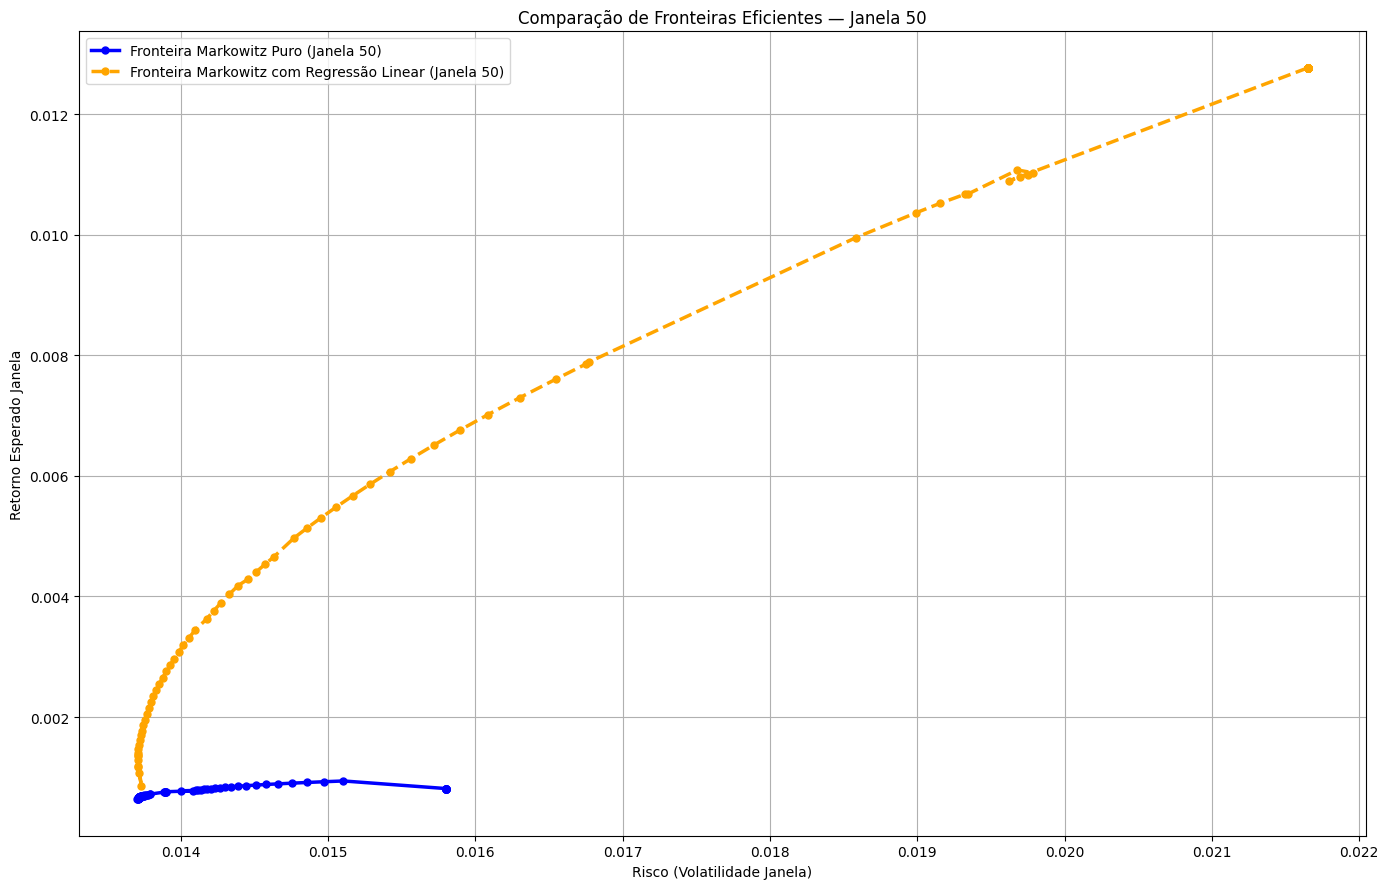

In [11]:
ret_curve, vol_curve, lambdas = compare_frontiers(models, window=window)


In [12]:
from outputs.charts.markowitz_plot import (
    find_lambda_for_risk,
    solve_markowitz,
    portfolio_volatility,
    portfolio_return
)

# from src.data.loader import load_prices, compute_returns
# from src.models.lr import predict_mean_returns
# from outputs.charts.markowitz_plot import compare_time_series, compare_frontiers
# from outputs.charts.models_markowitz import plot_LR_parity_return_prediction, plot_LR_parity_by_all_assets

def compare_time_series_local(
    models: list,
    target_risk=0.1
):
    """
    Compara o crescimento acumulado mensal de N modelos.

    Cada item de 'models':
    {
        "name": str,
        "mean_returns": pd.Series,
        "cov": pd.DataFrame,
        "color": str,
        "linestyle": str
    }
    """

    plt.figure(figsize=(14, 8))

    for model in models:

        name = model["name"]
        mean = model["mean_returns"]
        cov = model["cov"]
        returns_daily = model["returns_daily"]

        lamb = find_lambda_for_risk(mean, cov, target_risk)

        weights = solve_markowitz(mean, cov, lamb=lamb)

        print("Lambda {}, Name: {}, Volatility: {:.4f}, Return: {:.4f}".format(lamb, name, portfolio_volatility(weights, cov), portfolio_return(weights, mean)))

        port = returns_daily.dot(weights)


        acum = (1 + port).cumprod()
        plt.plot(
            acum.index, acum,
            # acum.index, acum,
            label=name,
            linewidth=2,
            color=model["color"],
            linestyle=model["linestyle"],
            marker='o', markersize=5
        )

    plt.title("Comparação Temporal dos Portfólios (Escala Mensal)")
    plt.xlabel("Tempo (Mensal)")
    plt.ylabel("Crescimento Acumulado")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Lambda 0.29, Name: Markowitz Puro (Janela 50), Volatility: 0.0140, Return: 0.0008
Lambda 0.79, Name: Markowitz com Regressão Linear (Janela 50), Volatility: 0.0140, Return: 0.0031


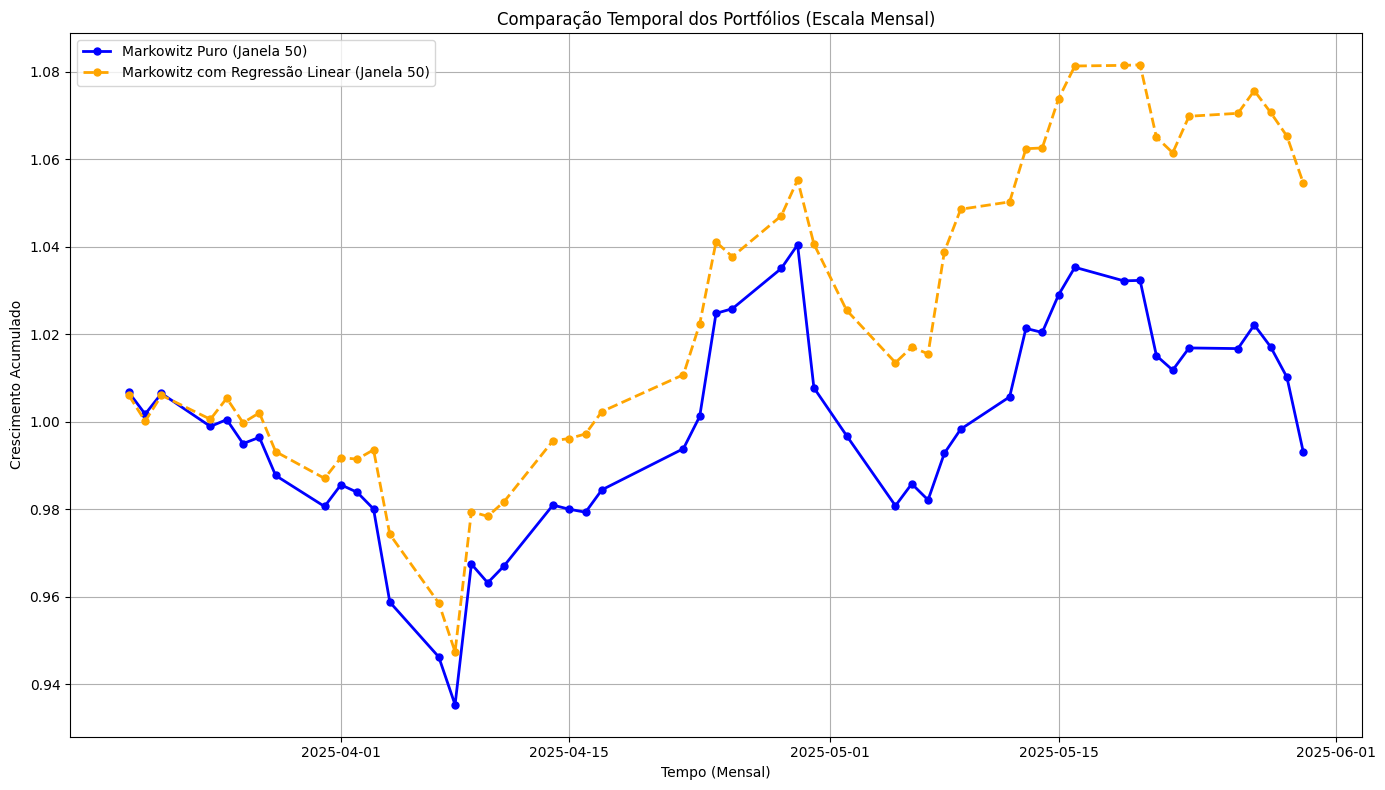

In [13]:
compare_time_series_local(models, target_risk=0.014)


,Model,Mean,Volatility,Sharpe,Cumulative_Return
0,standard_markowitz,0.000687,0.013731,0.793843,2.448597
0,linear_metrics,0.000670,0.013996,0.759467,2.302013
0,rnn_metrics,0.000781,0.014041,0.882484,3.159481


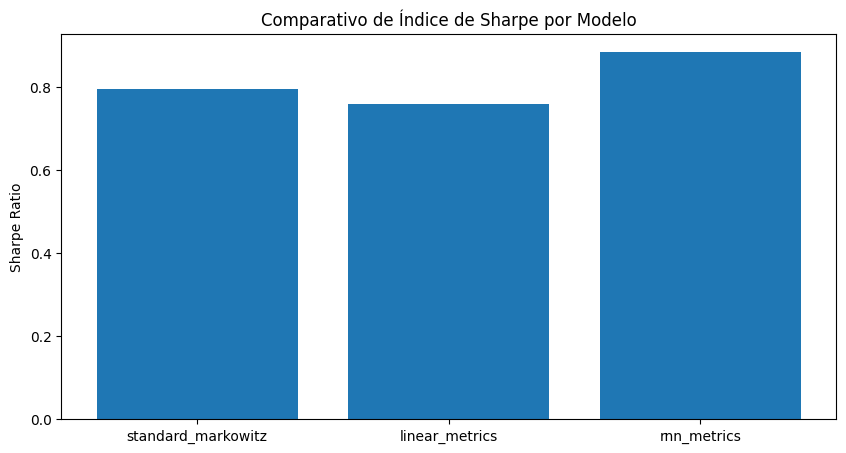

In [14]:
files = [
    "../outputs/models/standard_markowitz.csv",
    "../outputs/models/linear_metrics.csv",
    "../outputs/models/rnn_metrics.csv",
]

df_results = pd.concat([pd.read_csv(f) for f in files])
display(df_results)

plt.figure(figsize=(10, 5))
plt.bar(df_results["Model"], df_results["Sharpe"])
plt.title("Comparativo de Índice de Sharpe por Modelo")
plt.ylabel("Sharpe Ratio")
plt.show()


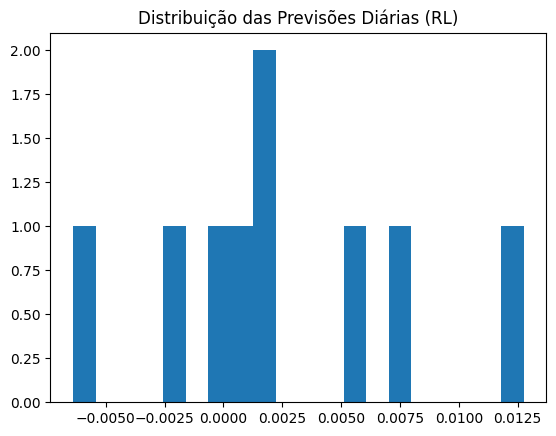

In [15]:
plt.hist(pred_daily, bins=20)
plt.title("Distribuição das Previsões Diárias (RL)")
plt.show()


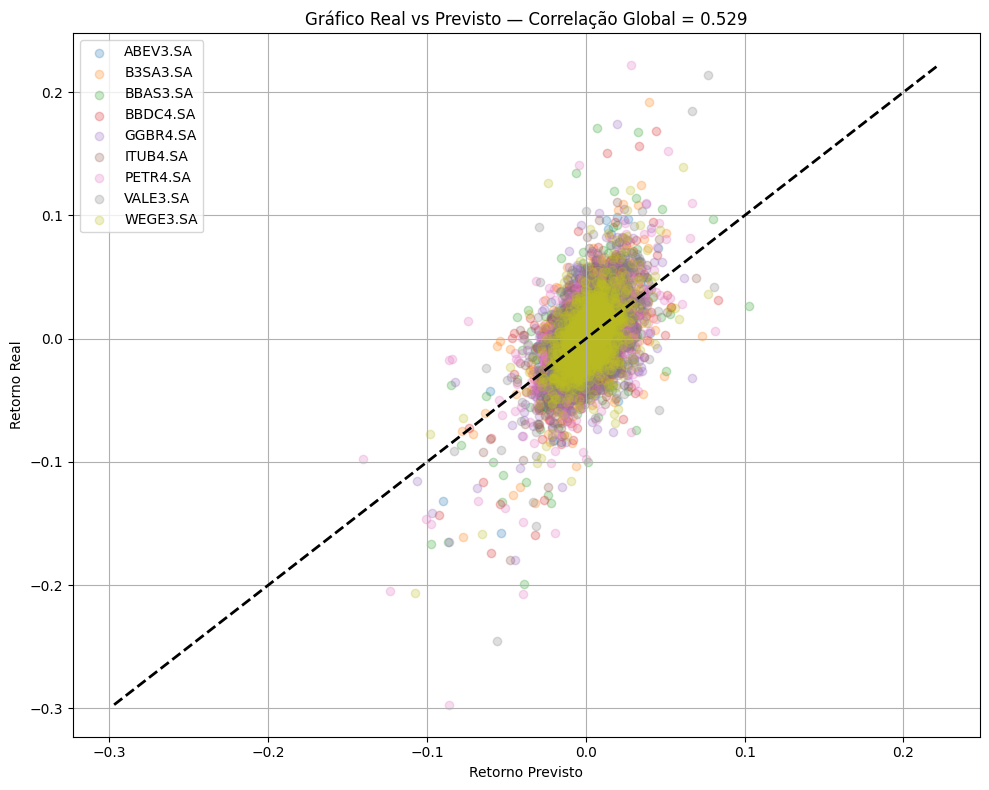

In [16]:
plot_LR_parity_return_prediction(prices, window=5)

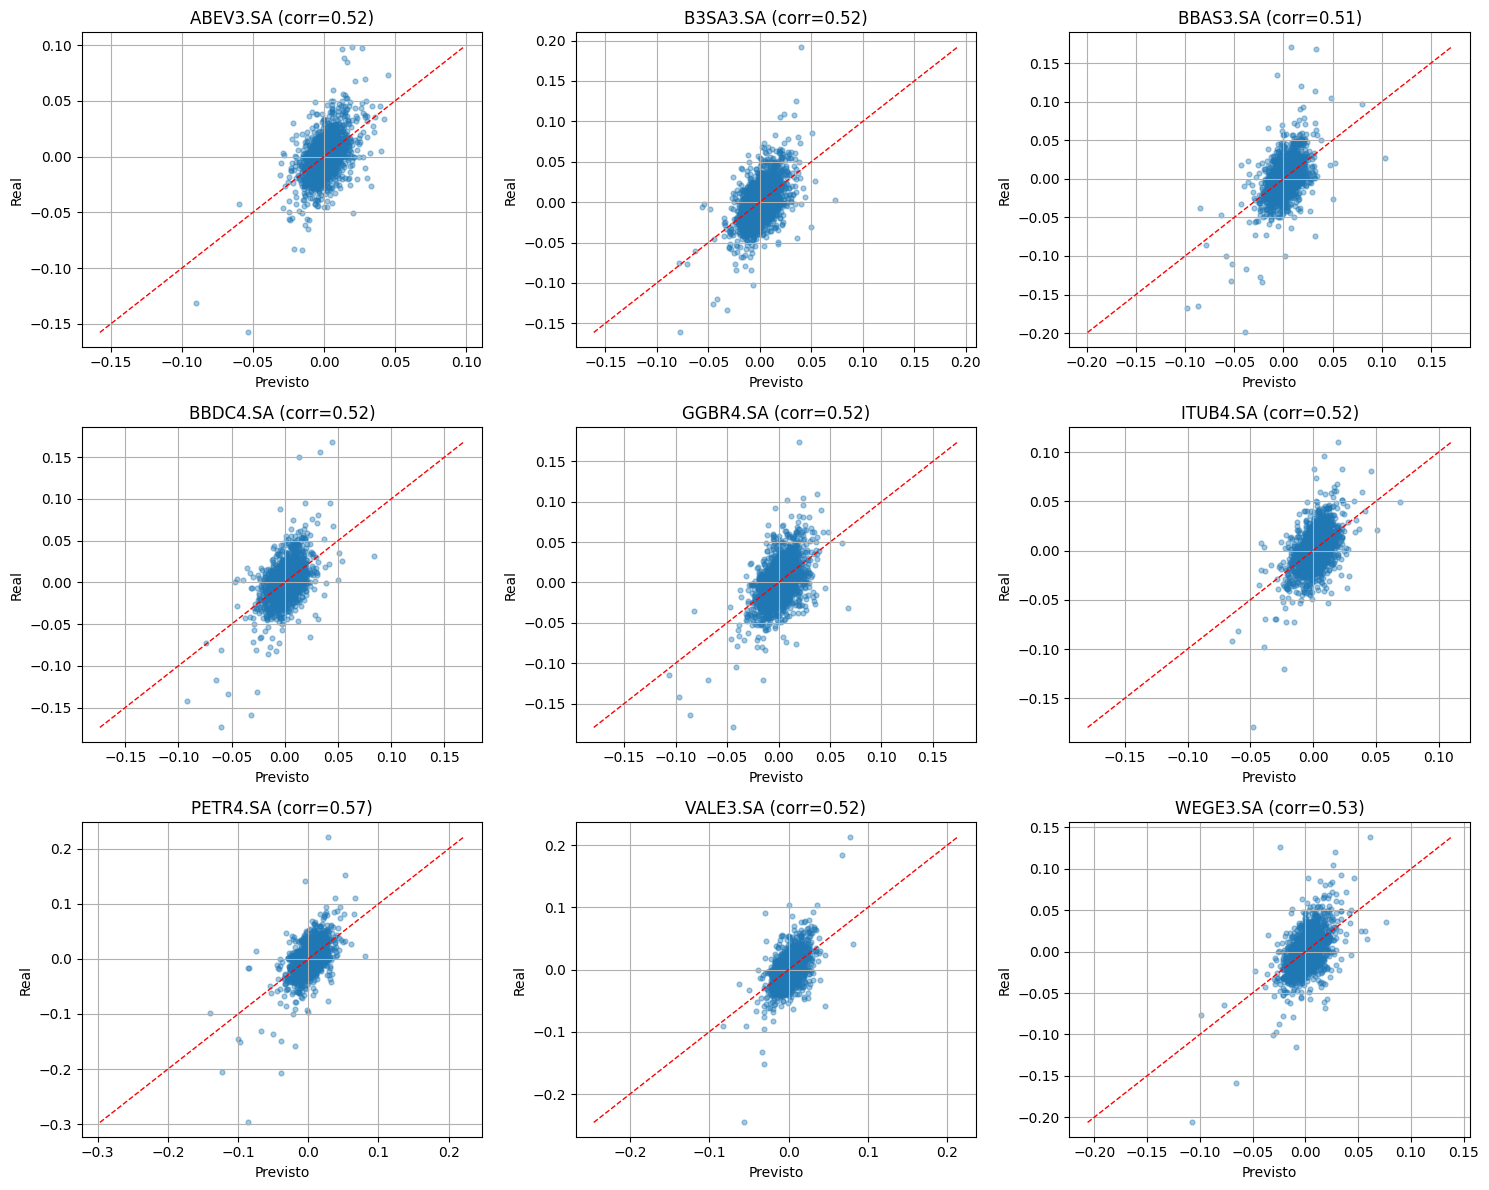

In [17]:
plot_LR_parity_by_all_assets(prices, window=5)